# Time DLHub Models
This notebooks demonstrates running models via DLHub, and charactizes their execution time as a function of molecular size

In [1]:
%matplotlib
from matplotlib import pyplot as plt 
from dlhub_sdk.client import DLHubClient
from time import perf_counter
from scipy.stats import sem
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

Using matplotlib backend: agg


In [2]:
client = DLHubClient()

In [3]:
model_name = 'loganw_globusid/g4mp2_delta_schnet'

## Get Example Molecules
Get some molecules with different numbers of atoms

In [4]:
data = pd.concat([
    pd.read_json(os.path.join('..', 'data', 'output', 'g4mp2_data.json.gz'), lines=True),
    pd.read_json(os.path.join('..', 'data', 'output', 'sugar_data.json'), lines=True)
], sort=False)

Get one molecule per molecule size

In [5]:
data.drop_duplicates('n_atom', inplace=True)

## Invoke Model for Each Different Molecule Sizes
We are going to run each molecule individually to get timing as a function of size

In [6]:
data['timing_err'] = data['timing'] = 0

In [7]:
for rid, mol in tqdm(data.iterrows()):
    # Run the simulation many times to evaluate the timing
    timings = []
    for i in range(64):
        start = perf_counter()
        client.run(model_name, ([mol['xyz']]*100, [mol['u0']]*100), input_type='json')
        end = perf_counter()
        timings.append(end - start)
    data.loc[rid, 'timing'] = np.mean(timings)    
    data.loc[rid, 'timing_err'] = sem(timings)    

28it [06:26, 14.42s/it]


## Plot the Sizes
Plot the invocation time as a function of molecule size

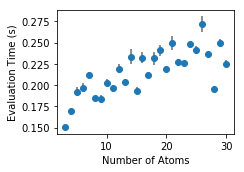

In [8]:
fig, ax = plt.subplots()

ax.errorbar(data['n_atom'], data['timing'], yerr=data['timing_err'], 
            linestyle='none', marker='o', ecolor='dimgray')
ax.set_xlabel('Number of Atoms')
ax.set_ylabel('Evaluation Time (s)')

fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'dlhub-run-time.png'), dpi=320)
fig.savefig(os.path.join('figures', 'dlhub-run-time.pdf'))